<a href="https://colab.research.google.com/github/nina1603/InternshipTestTask/blob/master/version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

%matplotlib inline

In [0]:
import matplotlib.pyplot as plt


def show_img_with_mask(img, mask, figsize=(14, 8)):
    """Shows image and mask.

    Parameters
    ----------
    img : np.ndarray
        Image.
    mask : np.ndarray
        Mask.
    figsize : tuple of 2 int, optional (default=(14, 8))
        Figure size.

    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img)
    ax2.imshow(mask)
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

In [0]:
import numpy as np


EPS = 1e-10


def dice(true, pred):
    """Dice score.

    Parameters
    ----------
    true : np.ndarray, 2d
         Ground truth mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.
    pred : np.ndarray, 2d
         Predicted mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.

    Returns
    -------
    float from 0 to 1
        Dice score. The greater the value of dice score the better.

    Notes
    -----
    Masks should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).

    """
    true = true.astype(bool)
    pred = pred.astype(bool)

    intersection = (true & pred).sum()
    im_sum = true.sum() + pred.sum()

    return 2.0 * intersection / (im_sum + EPS)


def get_dice(true, pred):
    """Mean dice score.

    Parameters
    ----------
    true : list[np.ndarray] or np.ndarray
         List of ground truth masks or one mask that consists of 2 unique values:
         0 - denotes background, 1 - denotes object.
    pred : list[np.ndarray] or np.ndarray
         List of predicted masks or one mask that consists of 2 unique values:
         0 - denotes background, 1 - denotes object.

    Returns
    -------
    float from 0 to 1
        Dice score or mean dice score in case then lists of masks are passed.
        The greater the value of dice score the better.

    Notes
    -----
    Masks should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).
    
    """
    assert type(true) == type(pred), "Types of true and pred should be the same."
    if isinstance(true, list):
        return np.mean([dice(t, p) for t, p in zip(true, pred)])
    elif isinstance(true, np.ndarray):
        return dice(true, pred)
    else:
        raise TypeError("Wrong type.")

In [0]:
import os
import numpy as np

from glob import glob
from PIL import Image
from datetime import datetime


def generate_html(path_to_data):
    """Generates content of html file and saves it.

    Parameters
    ----------
    path_to_data : str
        Path to data with original images, predicted masks, and cropped according masks images.

    Returns
    -------
    str
        Content of html file.

    """
    html = "\n".join(["<!doctype html>", "<html>", "<head>",
                      "<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>",
                      "<title>Визуализация результатов</title>", "</head>", "<body>",
                      "<table cellspacing='0' cellpadding='5'>"]) + "\n"
    paths_to_imgs = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_img.jpg")])
    paths_to_masks = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_pred_mask.png")])
    paths_to_crops = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_crop.png")])
    for ind, (path_to_img, path_to_mask, path_to_crop) in enumerate(zip(paths_to_imgs,
                                                                        paths_to_masks,
                                                                        paths_to_crops)):
        if not ind % 2:
            html += "<tr>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_img}'"
        html += "alt='Something went wrong.'"
        html += f"height='320' title='Original image:\n{path_to_img}'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_mask}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Predicted mask'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_crop}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Cropped img according\npredicted mask'></td>\n"
        if not ind % 2:
            html += "<td width='100'></td>\n"
        else:
            html += "</tr>\n"
    date = datetime.today().strftime("%Y-%m-%d-%H.%M.%S")
    html += f"</table>\n<i>The page was generated at {date}</i></body>\n</html>"
    filename = os.path.basename(path_to_data) + ".html"
    path_to_save = os.path.dirname(path_to_data)
    with open(f"{path_to_save}/{filename}", "w") as f:
        f.write(html)

    return html


def get_html(paths_to_imgs, pred_masks, path_to_save="results/test"):
    """Generates html file and saves it.

    Parameters
    ----------
    paths_to_imgs : list[str]
        List of paths to original images.
    pred_masks : list[np.ndarray]
        Predicted masks.
    path_to_save : str
        Path to save source images to put them in html file. Html name is the same as name of the
        last folder on `path_to_save` and is saved on upper level.

    Returns
    -------
    str
        Content of html file.

    """
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        Image.fromarray(pred_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")

    html = generate_html(path_to_save)

    return html

In [0]:
import numpy as np


def encode_rle(mask):
    """Returns encoded mask (run length) as a string.

    Parameters
    ----------
    mask : np.ndarray, 2d
        Mask that consists of 2 unique values: 0 - denotes background, 1 - denotes object.

    Returns
    -------
    str
        Encoded mask.

    Notes
    -----
    Mask should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).

    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)


def decode_rle(rle_mask, shape=(320, 240)):
    """Decodes mask from rle string.

    Parameters
    ----------
    rle_mask : str
        Run length as string formatted.
    shape : tuple of 2 int, optional (default=(320, 240))
        Shape of the decoded image.

    Returns
    -------
    np.ndarray, 2d
        Mask that contains only 2 unique values: 0 - denotes background, 1 - denotes object.
    
    """
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        img[low:high] = 1

    return img.reshape(shape)

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
!ls 'drive/My Drive/Colab Notebooks'

data  data.zip	GettingStarted.ipynb  liba  results  Untitled0.ipynb


In [0]:
%cd 'drive/My Drive/Colab Notebooks/'

/content/drive/My Drive/Colab Notebooks


In [0]:
#!unzip 'data.zip'
#!ls gdrive

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Colab Notebooks']


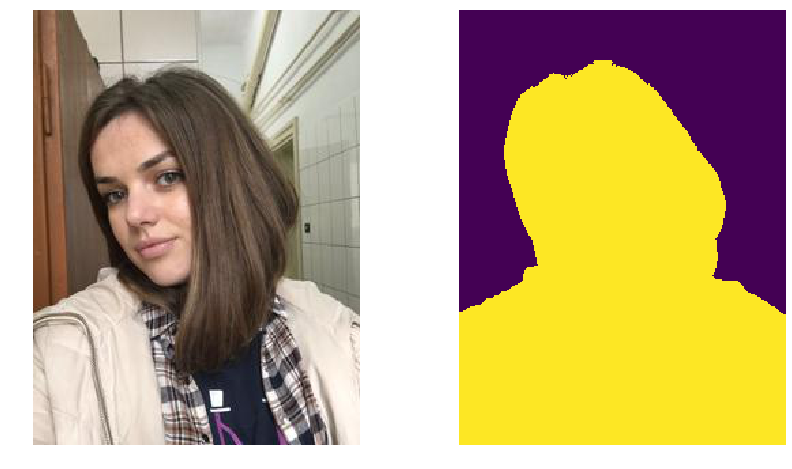

(320, 240)


In [0]:
#from liba import *
print(sys.path)
path = "data/train"
images = os.listdir(path)
ind = np.random.choice(images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
show_img_with_mask(img, mask)
print(mask.shape)

Пример подсчета метрики:

In [0]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.559506155809221

Можно для последовательности масок вычислить среднее значение метрики:

In [0]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.4999593896243263

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [0]:
rle_mask = encode_rle(mask)
rle_mask

'8980 13 9219 15 9460 13 9696 17 9714 2 9935 21 9957 2 10173 30 10412 33 10649 38 10888 41 11110 1 11126 45 11347 9 11363 1 11365 47 11587 11 11599 1 11601 2 11604 49 11826 12 11839 55 12065 14 12080 54 12303 73 12542 75 12780 78 13020 79 13100 1 13259 82 13494 1 13497 85 13733 91 13971 93 14210 96 14449 98 14687 101 14926 102 15166 103 15406 104 15644 106 15884 107 16123 109 16363 110 16603 111 16842 112 17082 113 17321 115 17561 116 17800 117 18040 118 18280 118 18519 120 18759 121 18999 122 19239 122 19478 124 19718 125 19958 126 20198 127 20437 128 20677 129 20917 130 21157 131 21396 133 21636 133 21876 134 22116 134 22356 135 22595 136 22835 136 23075 137 23315 138 23555 139 23794 140 24034 142 24274 142 24514 142 24754 142 24994 144 25234 145 25474 145 25714 146 25954 147 26194 148 26435 148 26675 149 26915 149 27155 151 27395 151 27635 152 27875 153 28116 152 28356 153 28596 154 28836 154 29076 155 29317 154 29557 155 29797 155 30038 154 30278 155 30518 155 30759 154 30999 154 3

Теперь восстановим маску:

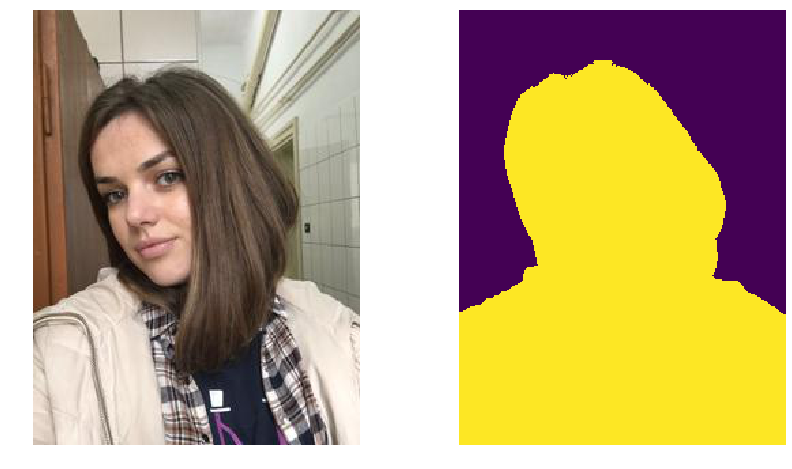

In [0]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [0]:
pred = pd.read_csv("data/pred_valid_template.csv")
pred.head()

,id,rle_mask
0,1315,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1,1316,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
2,1317,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
3,1318,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
4,1319,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...


Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [0]:
paths_to_imgs = sorted(glob("data/valid/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/valid_mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.

Один из самых широко используемых методов сегментации это U-Net like нейронные сети. Поэтому я решила применить этот подход здесь.

In [0]:
# sub-parts of the U-Net model

import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
      
# full assembly of the sub-parts to form the complete net

import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)


In [0]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch import optim
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

def get_square(img, pos):
    """Extract a left or a right square from ndarray shape : (H, W, C))"""
    h = img.shape[0]
    if pos == 0:
        return img[:, :h]
    else:
        return img[:, -h:]

def split_img_into_squares(img):
    return get_square(img, 0), get_square(img, 1)

def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

def resize_and_crop(pilimg, scale=0.5, final_height=None):
    w = pilimg.size[0]
    h = pilimg.size[1]
    newW = int(w * scale)
    newH = int(h * scale)

    if not final_height:
        diff = 0
    else:
        diff = newH - final_height

    img = pilimg.resize((newW, newH))
    img = img.crop((0, diff // 2, newW, newH - diff // 2))
    return np.array(img, dtype=np.float32)

def batch(iterable, batch_size):
    """Yields lists by batch"""
    b = []
    for i, t in enumerate(iterable):
        b.append(t)
        if (i + 1) % batch_size == 0:
            yield b
            b = []

    if len(b) > 0:
        yield b

def split_train_val(dataset, val_percent=0.05):
    dataset = list(dataset)
    length = len(dataset)
    n = int(length * val_percent)
    random.shuffle(dataset)
    return {'train': dataset[:-n], 'val': dataset[-n:]}


def normalize(x):
    return x / 255

def merge_masks(img1, img2, full_w):
    h = img1.shape[0]

    new = np.zeros((h, full_w), np.float32)
    new[:, :full_w // 2 + 1] = img1[:, :full_w // 2 + 1]
    new[:, full_w // 2 + 1:] = img2[:, -(full_w // 2 - 1):]

    return new


def get_ids(dir):
    """Returns a list of the ids in the directory"""
    return (f[:-4] for f in os.listdir(dir))


def split_ids(ids, n=2):
    """Split each id in n, creating n tuples (id, k) for each id"""
    return ((id, i)  for id in ids for i in range(n))


def to_cropped_imgs(ids, dir, suffix, scale):
    """From a list of tuples, returns the correct cropped img"""
    for id, pos in ids:
        im = resize_and_crop(Image.open(dir + id + suffix), scale=scale)
        yield get_square(im, pos)

def to_cropped_masks(ids, dir, suffix, scale):
    """From a list of tuples, returns the correct cropped img"""
    for id, pos in ids:
        im = resize_and_crop(Image.open(dir + id + suffix), scale=scale)
        im = (im > 0).astype(np.float32)
        yield get_square(im, pos)
        
def get_imgs_and_masks(ids, dir_img, dir_mask, scale):
    """Return all the couples (img, mask)"""
    imgs = to_cropped_imgs(ids, dir_img, '.jpg', scale)

    # need to transform from HWC to CHW
    imgs_switched = map(hwc_to_chw, imgs)
    imgs_normalized = map(normalize, imgs_switched)

    masks = to_cropped_masks(ids, dir_mask, '.png', scale)

    return zip(imgs_normalized, masks)


def get_full_img_and_mask(id, dir_img, dir_mask):
    im = Image.open(dir_img + id + '.jpg')
    mask = Image.open(dir_mask + id + '.png')
    return np.array(im), (np.array(mask) > 0).astype(np.int)

def eval_net(net, dataset, gpu=False):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    tot = 0
    count = 0
    for i, b in enumerate(dataset):
        img = b[0]
        true_mask = b[1]

        img = torch.from_numpy(img).unsqueeze(0)
        true_mask = torch.from_numpy(true_mask).unsqueeze(0)

        if gpu:
            img = img.cuda()
            true_mask = true_mask.cuda()

        mask_pred = net(img)[0]
        mask_pred = (mask_pred > 0.5).float()

        tot += dice_coeff(mask_pred, true_mask).item()
        count += 1
    return tot / (count + 1)
  
def train_net(net,
              epochs=5,
              batch_size=8,
              lr=0.1,
              save_cp=True,
              gpu=False,
              img_scale=0.5):

    dir_img = 'data/train/'
    dir_mask = 'data/train_mask/'
    val_img = 'data/valid/'
    val_mask = 'data/valid_mask/'
    dir_checkpoint = 'checkpoints/'

    ids = get_ids(dir_img)
    ids_val = get_ids(val_img)
    ids = list(split_ids(ids))

    ids_val = list(split_ids(ids_val))
    
    iddataset = {'train': ids, 'val': ids_val}
    N_train = len(iddataset['train'])
    print(N_train)
    print('''
    Starting training:
        Epochs: {}
        Batch size: {}
        Learning rate: {}
        Training size: {}
        Validation size: {}
        Checkpoints: {}
        CUDA: {}
    '''.format(epochs, batch_size, lr, len(list(iddataset['train'])),
               len(list(iddataset['val'])), str(save_cp), str(gpu)))


    optimizer = optim.SGD(net.parameters(),
                          lr=lr,
                          momentum=0.9,
                          weight_decay=0.0005)

    criterion = nn.BCELoss()

    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        # reset the generators
        train = get_imgs_and_masks(iddataset['train'], dir_img, dir_mask, img_scale)
        val = get_imgs_and_masks(iddataset['val'], val_img, val_mask, img_scale)

        epoch_loss = 0
        #print(list(batch(train, batch_size)))
        for i, b in enumerate(batch(train, batch_size)):
            imgs = np.array([i[0] for i in b]).astype(np.float32)
            true_masks = np.array([i[1] for i in b])

            imgs = torch.from_numpy(imgs)
            true_masks = torch.from_numpy(true_masks)

            if gpu:
                imgs = imgs.cuda()
                true_masks = true_masks.cuda()

            masks_pred = net(imgs)
            masks_probs_flat = masks_pred.view(-1)
            #print('pred',masks_probs_flat)
            
            true_masks_flat = true_masks.view(-1)
            #print('true',true_masks_flat)

            loss = criterion(masks_probs_flat, true_masks_flat)
            epoch_loss += loss.item()

            #print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch finished ! Loss: {}'.format(epoch_loss / batch_size))

        if 1:
            val_dice = eval_net(net, val, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))




In [0]:
net = UNet(n_channels=3, n_classes=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

train_net(net, gpu=True)

2630

    Starting training:
        Epochs: 5
        Batch size: 8
        Learning rate: 0.1
        Training size: 2630
        Validation size: 290
        Checkpoints: True
        CUDA: True
    
Starting epoch 1/5.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch finished ! Loss: 18.206162674352527
Validation Dice Coeff: 0.837719504161389
Starting epoch 2/5.
Epoch finished ! Loss: 14.762175912037492
Validation Dice Coeff: 0.8597310855216587
Starting epoch 3/5.
Epoch finished ! Loss: 13.251601254567504
Validation Dice Coeff: 0.8861918072520253
Starting epoch 4/5.
Epoch finished ! Loss: 12.009888414293528
Validation Dice Coeff: 0.8981586039271142
Starting epoch 5/5.
Epoch finished ! Loss: 10.883111434988678
Validation Dice Coeff: 0.9024690694825346
